### Name: Gabriel Ohaike
### Project#1 

#### **Import that Pandas package. We will use to hold the results of the queries, print Pandas tables, and print simple data visualizations.**

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### **Before we answer the project questions, Lets take a look at some of the important factors that would help in making an informed decision**

- **Exploring the GoBike dataset reveals that there are a total of 983,648 trips**

In [27]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*) as total_trip FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r6302a1a4b50635d3_00000172778ec3d3_1 ... (0s) Current status: DONE   
+------------+
| total_trip |
+------------+
|     983648 |
+------------+


**Are there more customers or subscribers making these trips?**

##### *Further breakdown on the trip showed that out of 983,648 trips, 136,809 which represent 13.9% are customers while 846,839 which represents 86.1% are subscribers*

In [77]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type, COUNT(*) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r7916783c906510fd_00000172786a5556_1 ... (0s) Current status: DONE   
+-----------------+--------+
| subscriber_type | count  |
+-----------------+--------+
| Customer        | 136809 |
| Subscriber      | 846839 |
+-----------------+--------+


### 1) **This brings us to our first project question**

- #### *What are the 5 most popular trips that you would call "commuter trips"?*

- Before we answer this question, let's explore and visualize different types of trips 

In [189]:
%%bigquery all_trip_freq
SELECT start_station_name, end_station_name, count(*) as all_trip_freq 
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY start_station_name, end_station_name ORDER BY all_trip_freq DESC LIMIT 20

In [190]:
all_trip_freq.head()

,start_station_name,end_station_name,all_trip_freq
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874


#### The trip table above shows all the five most popular trip stattion and the frequency. However, this does not give further information as per if all the trips are commuter trips or not.

- In order to answer this, let extract rush hours to give us an insight as to what type of trips are commuter trip

- Now, lets answer this question:

**What are the most busiest hours of the week?**

In [278]:
%%bigquery busiest_hour
SELECT EXTRACT(HOUR FROM start_date) as Hour, count(EXTRACT(HOUR FROM start_date)) as trip_count_weekday
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) 
GROUP BY Hour
ORDER BY trip_count_weekday DESC

In [279]:
busiest_hour.head()

,Hour,trip_count_weekday
0,8,128999
1,17,118332
2,9,90264
3,16,79000
4,18,78188


In [280]:
%%bigquery busiest_hour_allday
SELECT EXTRACT(HOUR FROM start_date) as Hour, count(EXTRACT(HOUR FROM start_date)) as trip_count_all
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY Hour
ORDER BY trip_count_all DESC

In [281]:
busiest_hour_allday.head()

,Hour,trip_count_all
0,8,132464
1,17,126302
2,9,96118
3,16,88755
4,18,84569


**The plot below compared the busiest trip time(hours) and counts for 7-day a week vs weekdays(Mon - Friday). Looking at both plots, they seemed to share common rush hours which is somewhere between 6 -10 in the morning and between 16 - 18 in the evening. Therefore, to get a true commuter trips, we need to consider only the trip for weekdays(Mon - Fri) and hours (6-10 & 16-8), this enables us to filter out commuters as chances are that there might be other users who are not commuters for example. GoBike technicians and maintenance team etc.**

<Figure size 864x648 with 0 Axes>

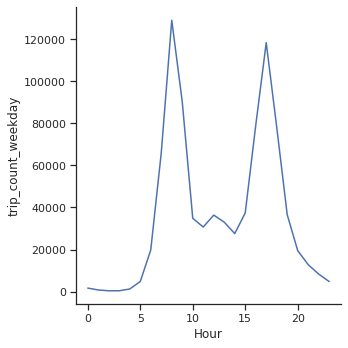

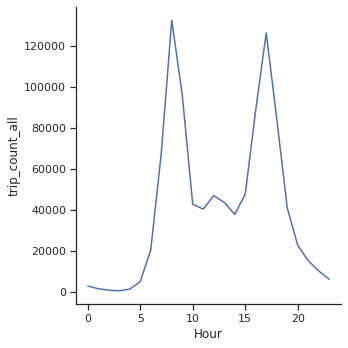

In [286]:
plt.figure(figsize=(12,9)) 
sns.relplot(x='Hour',y='trip_count_weekday',data=busiest_hour, kind="line")
sns.relplot(x='Hour',y='trip_count_all',data=busiest_hour_allday, kind="line")
pass

#### Finally, this led us into 5 most popular trips to identify commuter trips below. Obviously, high surge in rush hour like 8,9,16,17,18 is an evidence that those are commuters.

In [294]:
%%bigquery commuter_trip
SELECT count(trip_id) as trip_freq ,start_station_name, end_station_name,
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) AND EXTRACT(HOUR from start_date) IN (6,7,8,9,10,16,17,18,19)
GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 5

In [295]:
commuter_trip

,trip_freq,start_station_name,end_station_name
0,6352,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
1,5647,Harry Bridges Plaza (Ferry Building),2nd at Townsend
2,5454,2nd at Townsend,Harry Bridges Plaza (Ferry Building)
3,5218,Embarcadero at Sansome,Steuart at Market
4,5192,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building)


### **Second project Question**

### **What are your recommendations for offers (justify based on your findings)?**

**Before we make recommendations. let's look at the current [GoBike Pricing]('https://www.lyft.com/bikes/bay-wheels/pricing')**


### Summary of GoBike current offering:

- Annual Membership: 149.00 per annum. Free for the first 45 mins ride and 3.00 per 15 mins after
        
-  Monthly Membership:15.00 per month. Free for the first 45 mins ride and 3.00 per 15 mins after
        
- Single Ride: 2.00 for the first 30 mins and 3.00 per 15 mins after.
        
- Access Pass: 10.00 per day for the first 30 ride and 3.00 per 15 mins after.(but you bike station by station to save cost)
    
- Ebiking: Members pay 0.15/minute
  - Non-members pay 0.20/minute
  - Bike Share for All Members pay 0.05/minute with a cap of 1
  - Dock at any Bay Wheels station for free or use the cable to lock to a bike rack within the service area for 2. 
  - This charge will be waived if you park near a station that has no empty docks or park in part of the service area without stations. 
  - Always lock responsibly.This new pricing applies to ebike rides in San Francisco

**We begin by filtering the commutes that are within 30 mins** 

In [300]:
%%bigquery trip_time
SELECT (duration_sec/60), bike_number,start_station_id,end_station_id,subscriber_type 
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60)
ORDER BY duration_sec ASC

In [301]:
trip_time.head()

,f0_,bike_number,start_station_id,end_station_id,subscriber_type
0,1.0,35,83,83,Subscriber
1,1.0,382,63,63,Customer
2,1.0,238,63,63,Subscriber
3,1.0,500,76,76,Subscriber
4,1.0,372,67,67,Subscriber


In [325]:
%%bigquery trip_hr

SELECT EXTRACT(HOUR FROM start_date) AS HR_of_day, duration_sec,(duration_sec/60) as duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE ((EXTRACT(HOUR FROM start_date) IN (6,7,8,9)) OR (EXTRACT(HOUR FROM start_date) IN (15,16,17,18))) AND ((duration_sec/60) >= 5 AND (duration_sec/60) <= 60)
ORDER BY (duration_sec/60) DESC

In [326]:
trip_hr.head()

,HR_of_day,duration_sec,duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
0,15,3600,60.000000,Mechanics Plaza (Market at Battery),Embarcadero at Vallejo,Customer
1,16,3600,60.000000,2nd at Townsend,Grant Avenue at Columbus Avenue,Customer
2,9,3600,60.000000,San Francisco Caltrain (Townsend at 4th),Mechanics Plaza (Market at Battery),Subscriber
3,15,3599,59.983333,Embarcadero at Sansome,Grant Avenue at Columbus Avenue,Customer
4,15,3599,59.983333,Grant Avenue at Columbus Avenue,Grant Avenue at Columbus Avenue,Customer


In [ ]:
trip_hr.plot(kind='bar')

In [105]:
%%bigquery week_days_cummuters
SELECT EXTRACT(HOUR from start_date) AS hour, EXTRACT(DAYOFWEEK from start_date) as weekday,start_station_name, end_station_name,duration_sec,subscriber_type,
COUNT(*) as frequency 
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) AND EXTRACT(HOUR from start_date) IN (6,7,8,9,16,17,18,19) 
GROUP BY start_station_name,subscriber_type, end_station_name,duration_sec,hour,weekday ORDER BY frequency DESC LIMIT 5

In [106]:
week_days_cummuters

,hour,weekday,start_station_name,end_station_name,duration_sec,subscriber_type,frequency
0,8,3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,466,Subscriber,12
1,9,2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,248,Subscriber,10
2,8,4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,455,Subscriber,9
3,8,2,Harry Bridges Plaza (Ferry Building),2nd at Townsend,485,Subscriber,9
4,8,4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,481,Subscriber,9


In [122]:
 %%bigquery week_days
SELECT EXTRACT(HOUR FROM start_date) AS HR, EXTRACT(MINUTE FROM start_date) AS MIN,duration_sec, start_date, end_date, start_station_name,end_station_name
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE ((EXTRACT(HOUR FROM start_date) IN (6,7,8)) OR (EXTRACT(HOUR FROM start_date) IN (16,17,18,19))) AND (duration_sec >= 300 AND duration_sec <= 3600)
ORDER BY duration_sec DESC LIMIT 5

In [104]:
week_days

,HR,MIN,duration_sec,start_date,end_date,start_station_name,end_station_name
0,16,18,3600,2014-04-19 16:18:00+00:00,2014-04-19 17:18:00+00:00,2nd at Townsend,Grant Avenue at Columbus Avenue
1,16,4,3598,2014-04-07 16:04:00+00:00,2014-04-07 17:04:00+00:00,Embarcadero at Sansome,Powell Street BART
2,16,41,3598,2016-03-24 16:41:00+00:00,2016-03-24 17:41:00+00:00,San Salvador at 1st,San Salvador at 1st
3,17,15,3596,2015-05-16 17:15:00+00:00,2015-05-16 18:15:00+00:00,Powell at Post (Union Square),Powell at Post (Union Square)
4,16,0,3595,2016-05-05 16:00:00+00:00,2016-05-05 17:00:00+00:00,2nd at Townsend,2nd at Townsend


In [161]:

%%bigquery commuter_trip
SELECT EXTRACT(HOUR from start_date) AS hour, EXTRACT(DAYOFWEEK from start_date) as weekday,start_station_name,end_station_name,duration_sec,subscriber_type, COUNT(trip_id) as frequency,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) AND EXTRACT(HOUR from start_date) IN (6,7,8,9,16,17,18,19)
GROUP BY start_station_name,subscriber_type, end_station_name,duration_sec,hour,weekday
ORDER BY frequency DESC LIMIT 5

In [162]:
commuter_trip

,hour,weekday,start_station_name,end_station_name,duration_sec,subscriber_type,frequency
0,8,3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,466,Subscriber,12
1,9,2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,248,Subscriber,10
2,8,4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,455,Subscriber,9
3,8,2,Harry Bridges Plaza (Ferry Building),2nd at Townsend,485,Subscriber,9
4,8,4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,481,Subscriber,9


In [ ]:
%%bigquery trip_hr

SELECT EXTRACT(HOUR FROM start_date) AS HR, EXTRACT(MINUTE FROM start_date) AS MIN, duration_sec,start_station_name,end_station_name
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE ((EXTRACT(HOUR FROM start_date) IN (6,7,8,9)) OR (EXTRACT(HOUR FROM start_date) IN (15,16,17,18))) AND (duration_sec >= 300 AND duration_sec <= 3600)
ORDER BY duration_sec DESC